# Parameterizing SCME as rigid PBE water

What we need:
    
    a) Single molecule reference (DONE)
    b) PES for rigid dimer (DONE)
    c) Intrinsic multipole moments (DONE)
    d) Polarizabilities (DONE)
    e) 2- and 3-body sets (100 and 50) (DONE)
    f) Energies of lowest lying isomers of 3-6 H2O water clusters (rigid) (DONE)
    g) 2x(7,8,9,10,11,12) clusters taken from rigid PBE liquid simulation  (DONE)
    h) PBE Crystal ice-Ih (DONE)
    
    i) FIT
    ------
    ii) validation set : 180 (h2o)n n=7-12 clusters extracted from liquid simulations.
    


## a-c) Single molecule reference, PES and intrinsic moments:

a) A single water molecule is relaxed using the PBE energy functional as implemented in GPAW employing a finite-difference basis with a grid spacing of 0.18 Angstrom, and a vacuum of 7 Angstrom on all sides. Convergence criteria for density is set to 1e-8 and the structure is relaxed using the BFGS algorithm with a convergence criteria of maximum force = 0.001 eV/Angstrom.

Structural properties:

**rOH = 0.9708** Ang.
 
**rHH = 1.5307** Ang.

$\angle$**HOH = 104.0712** Deg.

b) First the dimer is relaxed with the internal geometry of each water molecule fixed and corresponding to the relaxed monomer. Same settings and criteria are applied as for the monomer.

Dimer properties:

**rOO =2.9087** Ang.

$\mathbf{E}_\mathrm{bind}$ **=-0.217268** eV.

```note
The relaxed monomer and dimer can be found in data : pbe_mon.xyz and pbe_dimer.xyz
```

The dimer binding energy is then explored for distances ranging from 2.4087 Ang to 4.9087 Ang at increments of 0.1 Ang, and translations are along the oxygen-to-oxygen vector. At each point all degrees of freedom are constraint. For
each distance the energy of each monomer is calculated due to the dependence of the energy on the relative grid space point distances and the PAW. Binding energy is $\mathbf{E}_\mathrm{bind} = \mathbf{E}_\mathrm{dimer} -  \mathbf{E}_\mathrm{mon1} -  \mathbf{E}_\mathrm{mon2}$.



```python
from ase import Atoms
from gpaw import GPAW
from gpaw.eigensolvers import RMMDIIS
from ase.io.trajectory import Trajectory
#from ase.constraints import FixAtoms
#from gpaw.utilities.watermodel import FixBondLengthsWaterModel as FixBondLengths
from ase.constraints import FixBondLengths
from ase.parallel import parprint, paropen
from ase.io import read
import numpy as np
from ase.visualize import view

# Read in VASP image
traj = Trajectory("dimer_fine_B.traj")
h2o = traj[-1]
h2o.center(vacuum=7.0)

cell = h2o.cell.copy()
cell[0,0] += 2.0
h2o.set_cell(cell)
h2o.center()

# unit vector between OO
rOO = h2o[0].position - h2o[3].position
rOO /= np.linalg.norm(rOO)

# translate 0.5 closer
pos = h2o.get_positions().copy()
pos[:3] -= 0.25 * rOO
pos[3:] += 0.25 * rOO

h2o.set_positions(pos)

gpaw_args = dict(convergence={'qpoles': 1e-06,
                              'dpoles': 1e-06,
                              'eigenstates': 1e-08,
                              'density': 1e-08},
                 h=0.20, xc='PBE',
                 eigensolver=RMMDIIS(niter=5))                                                   

# Loop over 25 images
X = np.arange(0,2.6,0.1)

f = paropen('Dimer.dat', 'w')
f.write("idx,rOO,Ebind,Edimer,E1,E2\n")

for i, val in enumerate(X):
    
    fix = FixBondLengths(c)

    h2o.constraints = fix

    calc = GPAW(**gpaw_args)
    h2o.set_calculator(calc)

    E_dimer = h2o.get_potential_energy()
    dOO = h2o.get_distance(0,3)

    # Monomers:
    mon1 = h2o[:3]
    mon1.set_calculator(GPAW(**gpaw_args))
    E1 = mon1.get_potential_energy()

    mon2 = h2o[3:]
    mon2.set_calculator(GPAW(**gpaw_args))
    E2 = mon2.get_potential_energy()

    E_bind = E_dimer - E1 - E2

    f.write("%5d %5.8f %5.8f %5.8f %5.8f %5.8f\n" %(i,dOO,E_bind,E_dimer,E1,E2))

    # Move dimer
    pos = h2o.get_positions().copy()
    pos[:3] += 0.05 * rOO
    pos[3:] -= 0.05 * rOO

    h2o.constraints = []
    h2o.set_positions(pos)

f.close()
```

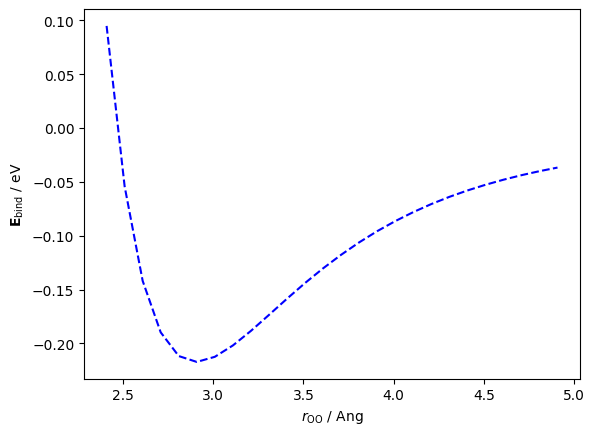

In [6]:
from matplotlib import pyplot as pl
import numpy as np

data = open("../data/Dimer_PBE.dat", "r")
lines = data.readlines()

E = []
R = []

for i, line in enumerate(lines):
    if i == 0:
        continue
    else:
        E.append(float(line.split()[2]))
        R.append(float(line.split()[1]))
    
pl.plot(R, E, 'b--')
pl.xlabel("$r_\mathrm{OO}$ / Ang")
pl.ylabel("$\mathbf{E}_\mathrm{bind}$ / eV")
pl.show()

c) For the electrostatic properties we use the general multipole expansion expressions from the "Single Center Expansions" document. 

\begin{align}
 \mu^\mathrm{QM}_\alpha &= \int \rho(\mathbf{r})r_\alpha d\mathbf{r} \\
 \theta^\mathrm{QM}_{\alpha\beta} &= \frac{1}{2!}\int \rho(\mathbf{r})(3r_\alpha r_\beta - r^2\delta_{\alpha\beta}) d\mathbf{r} \\
 \Omega^\mathrm{QM}_{\alpha\beta\gamma} &= \frac{1}{3!}\int \rho(\mathbf{r})(15r_\alpha r_\beta r_\gamma 
 - 3r^2(r_\alpha\delta_{\beta\gamma} + r_\beta\delta_{\alpha\gamma} + r_\gamma\delta_{\alpha\beta}))d\mathbf{r} \\
 \Phi^\mathrm{QM}_{\alpha\beta\gamma\delta} &= \frac{1}{4!}\int\rho(\mathbf{r})(105r_\alpha r_\beta r_\gamma r_\delta \nonumber \\
 &- 15r^2(r_\alpha r_\beta\delta_{\gamma\delta} + r_\alpha r_\gamma\delta_{\beta\delta} + r_\alpha r_\delta \delta_{\beta\gamma}
 + r_\beta r_\gamma\delta_{\alpha\delta} + r_\beta r_\delta\delta_{\alpha\gamma} + r_\gamma r_\delta \delta_{\alpha\beta}) \nonumber \\
 &+ 3r^4(\delta_{\alpha\beta}\delta_{\gamma\delta} + \delta_{\alpha\gamma}\delta_{\beta\delta} 
 + \delta_{\alpha\delta}\delta_{\beta\gamma}))d\mathbf{r}
\end{align}

Due to a finite dependence of the electrostatic properties on the relative positions of the PAW centers to the grid space the intrinsic moments are evaluated 27 times, corresponding to all possible permutations of $([\pm dx, 0], [\pm dy, 0], [\pm dz, 0])$, where $(dx, dy, dz)$ are half the grid spacing.

First the local reference frame of the monomer is aligned to the global reference frame such that the bisector axis (principal axis A) goes along the z-axis in the global frame ($\mathbf{e}^Z$). See figure below.

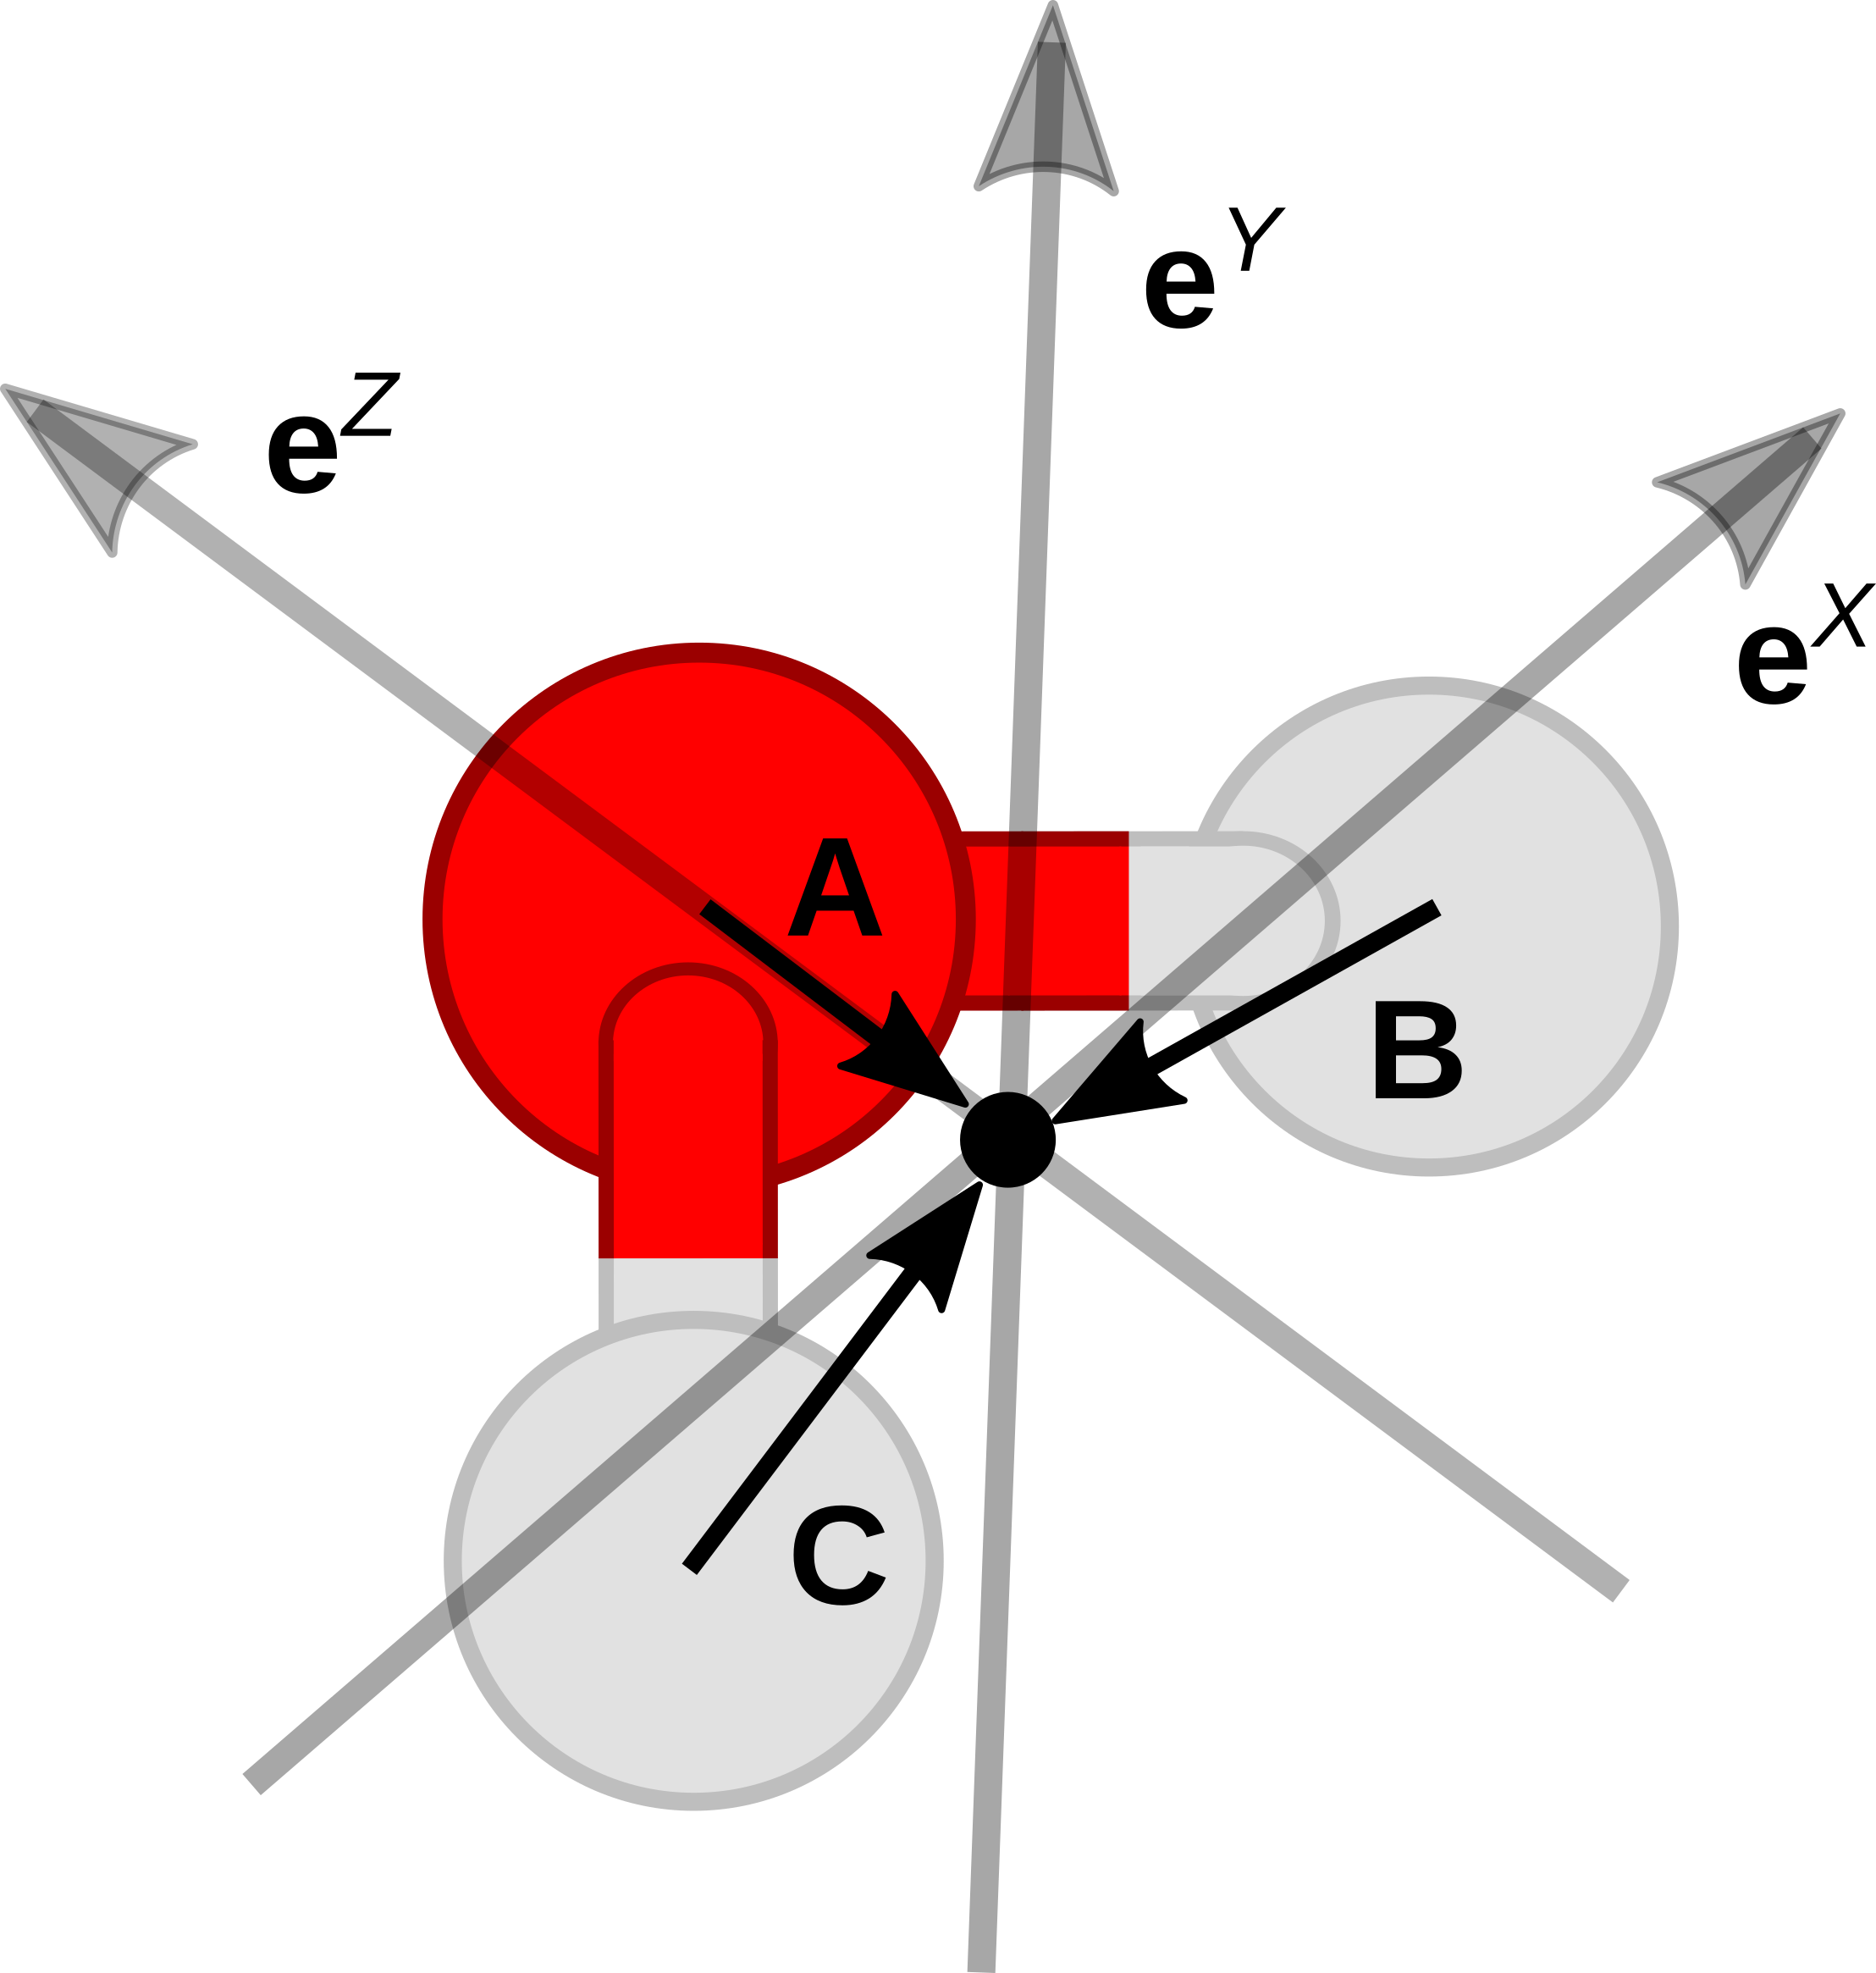

In [2]:
from IPython import display
display.Image("../data/watercartoon.png", width=322, height=336)

Figure. Local reference frame of the water molecule and principal axes. The bisector axis is defined in terms of vectors B and C, and coincides with vector A for the equilibrium structure.

Python script used is
```python
from ase import Atoms
from gpaw import GPAW
from gpaw.eigensolvers import RMMDIIS
from ase.parallel import parprint, paropen
from ase.io import read
import numpy as np
from ase.visualize import view

# Read in local-global ref frame monomer
h2o = read('monomer.xyz')

# Fix geometry to PBE results
for j in range(20):
    h2o.set_distance(0,1,0.97080,fix=0, mic=True)
    h2o.set_distance(0,2,0.97080,fix=0, mic=True)
    h2o.set_distance(1,2,1.53070,fix=0.5, mic=True)

h2o.center(vacuum=7.0)

gpaw_args = dict(convergence={'qpoles': 1e-06,
                              'dpoles': 1e-06,
                              'eigenstates': 1e-08,
                              'density': 1e-08},
                 h=0.18, xc='PBE',
                 eigensolver=RMMDIIS(niter=5))                                                   

hh = 0.09
# Make space of perturbations
x = np.array([-0.09, 0.0, 0.09])
y = np.array([-0.09, 0.0, 0.09])
z = np.array([-0.09, 0.0, 0.09])

# Empty moments
d = np.zeros(3)
q = np.zeros((3,3))
o = np.zeros((3,3,3))
h = np.zeros((3,3,3,3))

import _gpaw
from ase.units import Bohr

opos = h2o.get_positions().copy()

# Perturbe, 3**3 in total
for i, dx in enumerate(x):
    for j, dy in enumerate(y):
        for k, dz in enumerate(z):
            pos = opos.copy()
            pos[:,0] += dx
            pos[:,1] += dy
            pos[:,2] += dz

            h2o.set_positions(pos, apply_constraint=False)

            calc = GPAW(**gpaw_args)

            h2o.set_calculator(calc)
            E = h2o.get_potential_energy()

            CM = h2o.get_center_of_mass() / Bohr

            # Evaluate moments
            D_v = np.zeros(3)
            Q_v = np.zeros((3,3))
            O_v = np.zeros((3,3,3))
            H_v = np.zeros((3,3,3,3))

            _gpaw.calculate_moments(calc.density.finegd.beg_c,
                        calc.density.finegd.h_cv.diagonal().copy(),
                        CM,
                        calc.density.rhot_g,
                        D_v, Q_v, O_v, H_v,
                        np.array([0,0,0]), np.array([0,0,0]))

            calc.density.finegd.comm.sum(D_v)     
            calc.density.finegd.comm.sum(Q_v)
            calc.density.finegd.comm.sum(O_v)
            calc.density.finegd.comm.sum(H_v)

            parprint('dip', D_v)
            parprint('quad', Q_v)

            # Conversion factors included
            d -= 1. / 27. * D_v
            q -= 1. / 27. * Q_v * 0.5
            o -= 1. / 27. * O_v * 0.5 
            h -= 1. / 27. * H_v * 5.0 / 8.0

# Print irreducible to file
F = paropen('moments.dat', 'w')

F.write('dipole\n')
for i in range(3):
    F.write('%5d %5.8f\n' %(i, d[i]))

F.write('quadrupole\n')
for i in range(3):
    for j in range(i,3):
        F.write('%5d %5d %5.8f\n' %(i, j, q[i,j]))

F.write('octupole\n')                          
for i in range(3):                               
    for j in range(i,3):   
        for k in range(j,3):
            F.write('%5d %5d %5d %5.8f\n' %(i, j, k, o[i,j,k]))

F.write('hexadecapole\n')                          
for i in range(3):                               
    for j in range(i,3):        
        for k in range(j,3):
            for l in range(k,3):
                F.write('%5d %5d %5d %5d %5.8f\n' %(i, j, k, l, h[i,j,k,l]))

F.close()
```

The irreducible moments in the local frame are (PBE_moments.dat in data) 

| moments        | PBE         |SCME        |
| -------------- | ----------- |----------- |
| $\mu_z$        | -0.71134 | -0.72981 |
| $\theta_{xx}$  |  1.91016 |  1.95532 |
| $\theta_{yy}$  | -1.81512 | -1.85867 |
| $\theta_{zz}$  | -0.09504 | -0.09665 |
| $\Omega_{xxz}$ | -3.16816 | -3.27190 |
| $\Omega_{yyz}$ |  1.31624 |  1.36606 |
| $\Omega_{zzz}$ |  1.85192 |  1.90585 |
| $\Phi_{xxxx}$  | -0.90009 | -0.94903 |
| $\Phi_{xxyy}$  | -3.31926 | -3.38490 |
| $\Phi_{xxzz}$  |  4.21935 |  4.33393 |
| $\Phi_{yyyy}$  |  4.03300 |  4.09835 |
| $\Phi_{yyzz}$  | -0.71374 | -0.71345 |
| $\Phi_{zzzz}$  | -3.50561 | -3.62048 |

and are in a pretty good agreement with the current numerical values of the moments of the rigid SCME model.

## d) Polarizabilities

Polarizabilities : dipole-dipole ($\alpha_{\alpha\beta}$), dipole-quadrupole ($A_{\gamma,\alpha\beta}$), quadrupole-quadrupole ($C_{\gamma\delta,\alpha\beta}$) are calculated in Dalton using three different basis sets of increasing sizes : PVDZ, PVTZ, PVQZ, PV5Z. For each basis set the structure of the PBE monomer is relaxed.

The PV5Z is viewed as the cbs in this finite range, and the convergence is plotted wrt to the other basis sets. These values are shown below.

In a separate calculation the polarizabilities are evaluated with GPAW, using a perturpation scheme where fields and field gradients are created by using rank 1 and rank 2 RSSH densitites centered at the center of mass of the molecule. The dipole-dipole polarizability can be compared to a simpler scheme where a constant electric field is applied throughout the system.

| polariz        | PBE GPAW        | PBE Gaussian  | SCME        |
| -------------- | ----------- |----------- |----------- |
| $\alpha_{xx}$  | 10.886516 | 10.773518 | 10.31146 |
| $\alpha_{yy}$  | 10.718624 | 10.193148 | 9.54890 |
| $\alpha_{zz}$  | 10.745996 | 10.372222 | 9.90656 |
| $A_{x,xz}$  |  | -8.3080 | -8.42037 |
| $A_{y,yz}$ |  | -3.5380 | -1.33400 |
| $A_{z,xx}$ |  | -1.7617 | -2.91254 |
| $A_{z,yy}$ |  | 5.2250 |  4.72407 |
| $A_{z,zz}$  |  | -3.4633 | -1.81153 |
| $C_{xx,xx}$  |  | 15.51667 | 12.11907 |
| $C_{xx,yy}$  |  | -8.43833 | -6.95326 |
| $C_{xx,zz}$  |  | -7.07833 | -5.16582 |
| $C_{xy,xy}$  |  | 12.12000 |  7.86225 |
| $C_{xz,xz}$  |  | 14.46000 | 11.98862 |
| $C_{yy,yy}$  |  | 16.31167 | 11.24741 |
| $C_{yy,zz}$  |  | -7.87334 | -4.29415 |
| $C_{yz,yz}$  |  | 11.70000  | 6.77226 |
| $C_{zz,zz}$  |  | 14.95167 |  9.45997 |

## e-f) Two- and three-body sets and small clusters (3-6 H2O)

From the rigid ts-ccspol 2-body dataset (2500 dimer configurations), 100 are chosen at random and calculated at the GPAW PBE level. First the internal structure of each monomer is fixed to the PBE monomer results, and the dimer and both monomer energies calculated to give the binding energy. Similarly 
from the mbpol-trimer 3-body dataset (12000 trimer configurations), 50 are chosen at random and calculated at the GPAW PBE level, following the same procedure as for the 2-body dataset.

Scripts:

### DIMERS
```python
from ase import Atoms
from gpaw import GPAW
from gpaw.eigensolvers import RMMDIIS
from ase.parallel import parprint
from ase.io import read
from ase.parallel import paropen, world
import numpy as np
import random

# Read in VASP image
traj = read('ts-ccpol.xyz', index=':')

# Generate a random sample
sample = random.sample(range(0,len(traj)),100)
sample = np.array(sample)

# Broadcast from MASTER to all
world.broadcast(sample, 0)

gpaw_args = dict(convergence={'eigenstates': 1e-08,
                              'density': 1e-08},
                 h=0.18, xc='PBE',
                 eigensolver=RMMDIIS(niter=5))

f = paropen('2-set.dat', 'w')
f.write("idx,val,rOO,Ebind,Edimer,E1,E2\n")


# Loop over sample
for i, val in enumerate(sample):

    h2o = traj[val]
    h2o.center(vacuum=7.0)

    # Fix structure
    for j in range(20):
        h2o.set_distance(0,1,0.9708000000000,fix=0, mic=True)
        h2o.set_distance(0,2,0.9708000000000,fix=0, mic=True)
        h2o.set_distance(1,2,1.5307000000000,fix=0.5, mic=True)

        h2o.set_distance(3,4,0.9708000000000,fix=0, mic=True)
        h2o.set_distance(3,5,0.9708000000000,fix=0, mic=True)
        h2o.set_distance(4,5,1.5307000000000,fix=0.5, mic=True)

    calc = GPAW(**gpaw_args)

    dOO = h2o.get_distance(0,3)

    h2o.set_calculator(calc)

    E_dimer = h2o.get_potential_energy()

    # Monomers:
    mon1 = h2o[:3]
    mon1.set_calculator(GPAW(**gpaw_args))
    E1 = mon1.get_potential_energy()

    mon2 = h2o[3:]
    mon2.set_calculator(GPAW(**gpaw_args))
    E2 = mon2.get_potential_energy()

    E_bind = E_dimer - E1 - E2

    f.write("%5d %5d %5.8f %5.8f %5.8f %5.8f %5.8f\n" %(i,val,dOO,E_bind,E_dimer,E1,E2))
```

### TRIMERS
```python
from ase import Atoms
from gpaw import GPAW
from gpaw.eigensolvers import RMMDIIS
from ase.parallel import parprint
from ase.io import read
from ase.parallel import paropen, world
import numpy as np
import random

# Read in VASP image
traj = read('trimers.xyz', index=':')

# Generate a random sample
sample = random.sample(range(0,len(traj)),50)
sample = np.array(sample)

# Broadcast from MASTER to all
world.broadcast(sample, 0)

gpaw_args = dict(convergence={'eigenstates': 1e-08,
                              'density': 1e-08},
                 h=0.18, xc='PBE',
                 eigensolver=RMMDIIS(niter=5))

f = paropen('3-set.dat', 'w')
f.write("idx,val,Ebind,Edimer,E1,E2,E3\n")


# Loop over sample
for i, val in enumerate(sample):

    h2o = traj[val]
    h2o.center(vacuum=7.0)

    # Fix structure
    for j in range(20):
        h2o.set_distance(0,1,0.9708000000000,fix=0, mic=True)
        h2o.set_distance(0,2,0.9708000000000,fix=0, mic=True)
        h2o.set_distance(1,2,1.5307000000000,fix=0.5, mic=True)

        h2o.set_distance(3,4,0.9708000000000,fix=0, mic=True)
        h2o.set_distance(3,5,0.9708000000000,fix=0, mic=True)
        h2o.set_distance(4,5,1.5307000000000,fix=0.5, mic=True)

        h2o.set_distance(6,7,0.9708000000000,fix=0, mic=True)                         
        h2o.set_distance(6,8,0.9708000000000,fix=0, mic=True)                         
        h2o.set_distance(7,8,1.5307000000000,fix=0.5, mic=True)

    calc = GPAW(**gpaw_args)

    h2o.set_calculator(calc)

    E_trimer = h2o.get_potential_energy()

    # Monomers:
    mon1 = h2o[:3]
    mon1.set_calculator(GPAW(**gpaw_args))
    E1 = mon1.get_potential_energy()

    mon2 = h2o[3:6]
    mon2.set_calculator(GPAW(**gpaw_args))
    E2 = mon2.get_potential_energy()

    mon3 = h2o[6:]           
    mon3.set_calculator(GPAW(**gpaw_args))
    E3 = mon3.get_potential_energy()

    E_bind = E_trimer - E1 - E2 - E3

    f.write("%5d %5d %5.8f %5.8f %5.8f %5.8f %5.8f\n" %(i,val,E_bind,E_trimer,E1,E2,E3))
```

Results are given in data: 2-set.dat, 3-set.dat
Sets are given in data: ts-ccpol.xyz, trimers.xyz

#### Lowest lying isomers of (H2O)n n=2-6

Internal monomer structures are again fixed to the isolated PBE molecule structure, and the overall structure relaxed to 0.005 eV/Ang. See cartoon below for the isomers. Table below shows the interaction energy, and interaction (binding) energy per monomer.

|                             | Cs          | UUD        | S4         | CYC        | prism      |
| --------------              | ----------- |----------- | -----------| -----------| -----------|   
|$\mathbf{E}_\mathrm{bind}$   | -0.217268 | -0.673017 | -1.195165 | -1.578668 | -1.916297 |
|$\mathbf{E}_\mathrm{bind}/n$ | -0.108634 | -0.224339 | -0.298791 | -0.315734 | -0.319383 |



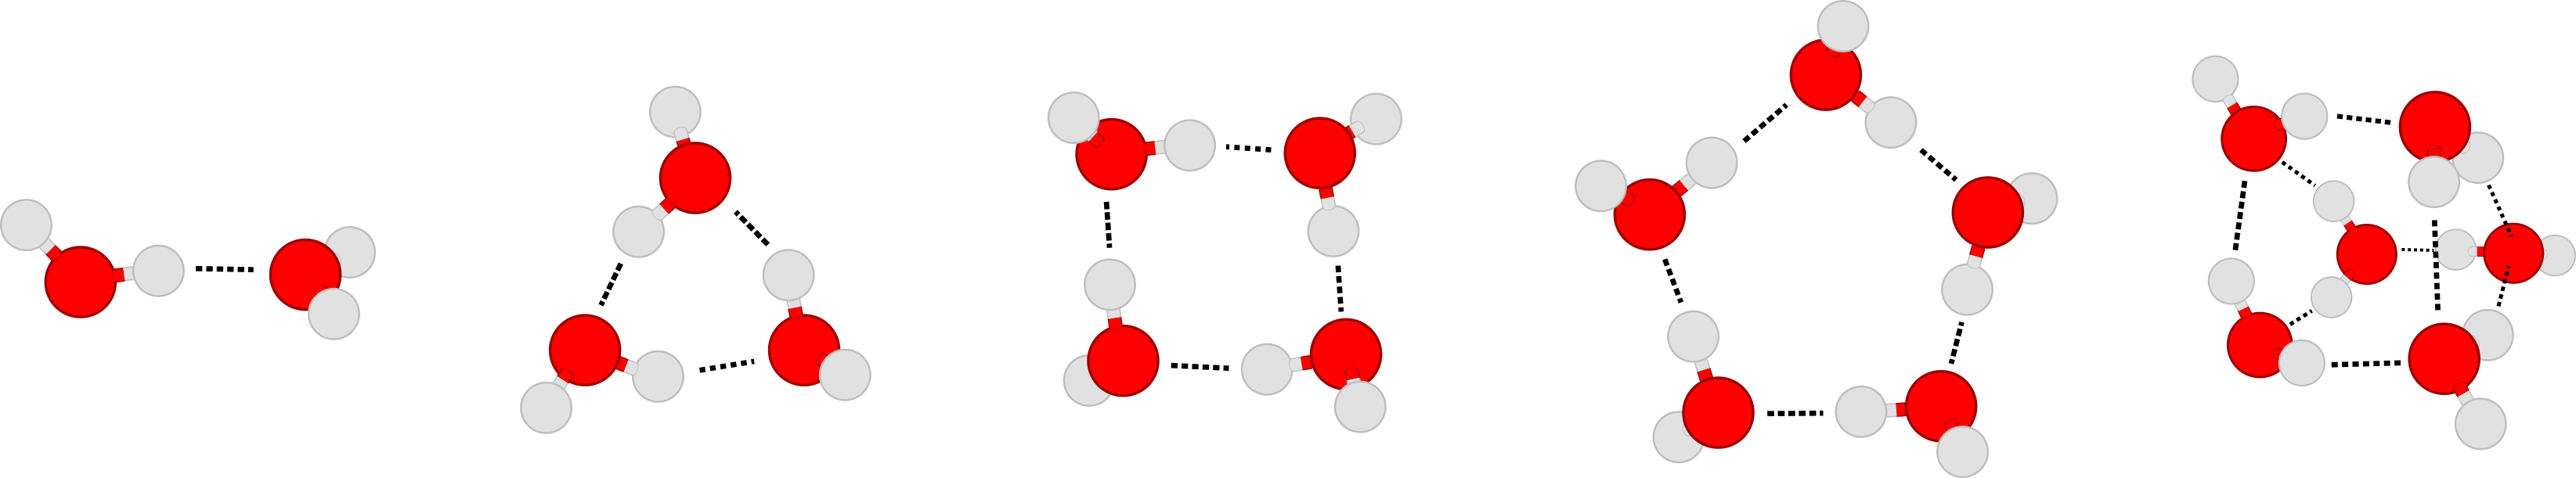

In [1]:
from IPython import display
display.Image("../data/smallcartoon.png", width=522, height=136)

Figure. Lowest lying isomers of water clusters (H2O)n n=6.

## g) Larger clusters extracted from PBE liquid simulations

We decided that part of the training set should be water clusters with sizes $n$ = 7 to 12 which are taken from AIMD simulations of [water near a graphene surface](page:water_graphene_qmmm) to train the influence of the surface.

To this end, the trajectory containing 100 ps of *NVT* AIMD simulations of 4 layer (32 molecules) of water near a 32-atomic graphene surface [simulated earlier](page:water_graphene_qmmm) was used to randomly sample images.

In total, 31 clusters for each size of 7 to 12 water molecules were randomly sampled from the trajectory (186 total structures). The following workflow was used:

1. Randomly pick an image from the trajectory.

1. Randomly pick a water molecule from the image.

1. Select the $n-1$ water molecules nearest the random pick and isolate all molecules as a cluster.

1. Wrap the cluster so that all molecules are continuous (not broken over PBCs), remove the PBCs, and place the cluster in a new box with 5 A safety padding in each cell dimension.

1. Calculate the total energy of the cluster and save the structure and calculation results.

1. Calculate the total energy of each monomer of the cluster and save the structure and calculation results.

1. Calculate the binding energy as $\Delta E_\mathrm{bind}^\mathrm{cluster} = E_\mathrm{tot}^\mathrm{cluster} - \sum_n E^{\mathrm{monomer}_n}_\mathrm{tot}$.

All calculations are performed with a vanilla install of GPAW 22.1.0.

The following script was used to extract the data and perform the calculations (it has a dependency on [asetools](https://gitlab.com/bjk24/asetools)):

```python
import os
import numpy as np
import pandas as pd

from gpaw import GPAW
from gpaw.eigensolvers import RMMDIIS

from ase import Atoms
from ase.io import write
from ase.io.trajectory import Trajectory

from asetools.geotools import molwrap, vacuum_padding

# Prepare file structure.
if not os.path.exists("random_images"):
    os.makedirs("random_images")

# Define GPAW arguments.
gpaw_args = dict(convergence={'eigenstates': 1e-08,
                              'density': 1e-08},
                 h=0.20, xc='PBE',
                 eigensolver=RMMDIIS(niter=5))

# Read trajectory.
traj = Trajectory("aimd-4layer.traj")
nimages = len(traj)
idx_waters = [atom.index for atom in traj[0] if atom.symbol == "O"]

# Results array. Structure: [nmols, sample, Etot_cluster, Ebind]
results = []

# Water clusters: n = 7 to 12.
for nmols in range(7, 13):
    print("\nCluster (H2O)_{:d}".format(nmols))

    # Prepare folder structure.
    if not os.path.exists("random_images/{:02d}".format(nmols)):
        os.makedirs("random_images/{:02d}".format(nmols))

    # Pick 31 random samples.
    for sample in range(31):
        rng_image = np.random.randint(0, nimages)
        atoms = traj[rng_image]

        # From random image, pick random water molecule.
        rng_water = np.random.randint(0, len(idx_waters))
        rng_water_idx = idx_waters[rng_water]

        # Calculate distances to all other O atoms.
        dOO = atoms.get_distances(rng_water_idx, idx_waters, mic=True)
        Olist = sorted(zip(dOO, idx_waters))

        # Pick the (nmols - 1) O atoms closest to the random pick. 
        # Exclude first entry (self-interaction, d=0).
        _, O_neighbors = zip(*Olist)
        O_selection = O_neighbors[1:nmols+1]

        # For each O atom, identify closest 2 H atoms and add to new atoms object.
        # Inherit cell and PBC for now.
        cluster = Atoms()
        cluster.cell = atoms.cell
        cluster.pbc = atoms.pbc
        idx_H = [atom.index for atom in atoms if atom.symbol == "H"]
        for O_idx in O_selection:

            # Identify closest 2 H atoms.
            dOH = atoms.get_distances(O_idx, idx_H, mic=True)
            Hlist = sorted(zip(dOH, idx_H))
            H1_idx = Hlist[0][1]
            H2_idx = Hlist[1][1]

            # Generate the monomer.
            cluster += atoms[O_idx, H1_idx, H2_idx]

        # Wrap the cluster around the periodic boundaries. Molwrap then
        # makes sure all molecules remain intact. Finally remove PBCs
        # and reduce the cell to minimum size + 5 A safety padding.
        cluster.wrap(pretty_translation=True)
        cluster = molwrap(cluster, natoms=3)
        cluster.pbc = False
        cluster = vacuum_padding(cluster, vacuum=5)

        # Calculate total energy of cluster.
        cluster.calc = GPAW(**gpaw_args)
        Etot_cluster = cluster.get_total_energy()

        # Write cluster atoms object (and calc results) to file.
        write("random_images/{:02d}/image_{:02d}.traj".format(nmols, sample), cluster)

        # Set up folder structure.
        if not os.path.exists("random_images/{:02d}/image_{:02d}_monomers".format(
                              nmols, sample)):
            os.makedirs("random_images/{:02d}/image_{:02d}_monomers".format(
                         nmols, sample))

        # Calculate the total energy of each monomer.
        Etot_monomers = []
        for i in range(nmols):
            n = i * 3
            monomer = cluster[n:n+3]
            monomer.calc = GPAW(**gpaw_args)
            Etot = monomer.get_total_energy()
            Etot_monomers.append(Etot)

            # Write monomer atoms object (and calc results) to file.
            write("random_images/{:02d}/image_{:02d}_monomers/monomer_{:02d}.traj".format(
                  nmols, sample, i), monomer)

        # Calculate binding energy.
        Ebind = Etot_cluster - sum(Etot_monomers)

        # Save results.
        results.append([nmols, sample, Etot, Ebind])

# Write results first to DataFrame and then to file.
columns = ["water cluster size", "sample #", "total energy / eV", "binding energy / eV"]
df = pd.DataFrame(results, columns=columns)
df.to_csv("20230414_water_clusters_aimd.csv")
```

The following plot visualizes the spread of binding energy values as a function of cluster size from the generated .csv file:

Text(0, 0.5, '$\\Delta E_\\mathrm{bind}$ / eV')

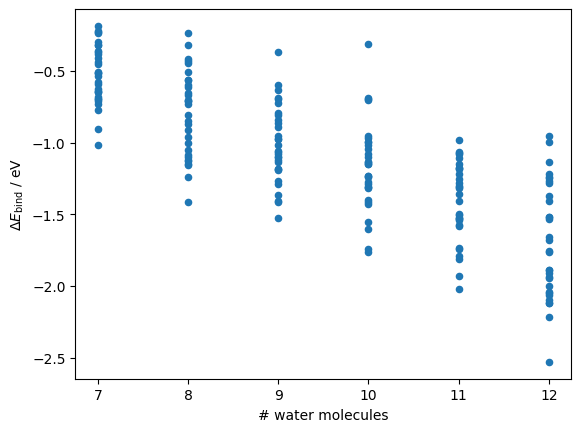

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/20230414_water_clusters_aimd.csv")
fig, ax = plt.subplots(1, 1)
df.plot.scatter(x="water cluster size", y="binding energy / eV", ax=ax)
ax.set_xlabel("# water molecules")
ax.set_ylabel("$\Delta E_\mathrm{bind}$ / eV")

## h) Crystal ice-Ih

|     Vol./n       | $\mathbf{E}_\mathrm{coh}$ |  $\mathbf{E}_\mathrm{coh}$/n | 
| -------------- | ----------- |----------- |
| 29.745665 | -56.440458 | -0.587921 |
| 30.514950 | -56.930161 | -0.593023 |
| 31.284234 | -57.224262 | -0.596086 |
| 32.053519 | -57.319996 | -0.597083 |
| 32.822803 | -57.286621 | -0.596736 |
| 33.592087 | -57.117458 | -0.594974 |
| 34.361372 | -56.838574 | -0.592068 |

Script:

```python
from ase import Atoms
from gpaw import GPAW
from gpaw.eigensolvers import RMMDIIS
from ase.parallel import parprint
from ase.io import read
from ase.parallel import paropen, world, parprint
from gpaw.utilities.watermodel import FixBondLengthsWaterModel as FixBondLengths
from ase.optimize import QuasiNewton as BFGS
from ase.visualize import view
import numpy as np
from ase.io import read

def molpairs(atoms):
    rattle = ([((3 * i + j), (3 * i + (j + 1) % 3))
                        for i in range((len(atoms)) // 3)
                        for j in [0, 1, 2]])
    return rattle

def fix_struct(atoms, pairs):
    for j in range(20):
        atoms.set_distance(pairs[0][0],pairs[0][1],0.9708000,fix=0, mic=True)
        atoms.set_distance(pairs[2][0],pairs[2][1],0.9708000,fix=0, mic=True)
        atoms.set_distance(pairs[1][0],pairs[1][1],1.5307000,fix=0.5, mic=True)
    return atoms

a = np.array([0.092800, 0.952000, 0.976000, 1.000000,
              1.024000, 1.048000, 1.072000])

for i, val in enumerate(a):
    # Read in structures
    sys = read('ice-%1.3f.xyz' %val)
    sys.pbc = (True, True, True)

    monomers = []
    for i in range(len(sys) // 3):
        mon = [i*3, i*3+1, i*3+2]
        monomers.append(mon)

    gpaw_args = dict(convergence={'eigenstates': 1e-08,
                                  'density': 1e-06},
                     h=0.18, xc='PBE')
                     #eigensolver=RMMDIIS(niter=5))
    
    rattle = molpairs(sys)
    
    h2o = sys.copy()
    
    c = FixBondLengths(rattle)
    h2o.set_constraint(c)
    
    # Relax structure
    calc = GPAW(**gpaw_args)
    h2o.set_calculator(calc)
    
    dyn = BFGS(h2o, trajectory='ice-%1.3f-opt.traj' %val)
    dyn.run(fmax=0.05)

    #
    E_ice = h2o.get_potential_energy()
    # Loop over all monomers and get cohesive energy
    for j, n in enumerate(monomers):
        mon = h2o[n]
        mon.set_calculator(GPAW(**gpaw_args))
        E_mon = mon.get_potential_energy()
        E_ice -= E_mon
 
    parprint('E_coh: %5.6f' %(E_ice))
```

Structures contain 96 proton disordered water molecules in the regular hexagonal lattice. See ice.xyz in data. The volume / energy curve gives the minimum volume, cohesive energy and bulk modulus.

13.186884373738515 GPa
32.20697568737189 V0
-0.5971824274945412 E0


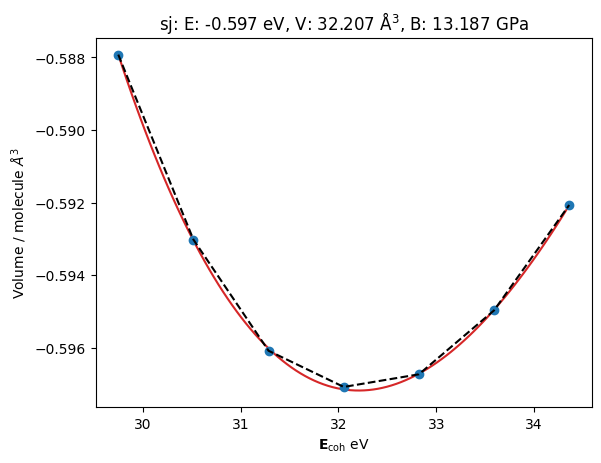

In [1]:
from ase.units import kJ                                                                             
from ase.eos import EquationOfState
import numpy as np
import pylab as pl
 
volume = np.array([29.745665,30.514950,31.284234,
                   32.053519,32.822803,33.592087,
                   34.361372])
 
energy = np.array([-56.440458,-56.930161,-57.224262,
                   -57.319996,-57.286621,-57.117458,
                   -56.838574])
energy /= 96.0
 
eos = EquationOfState(volume, energy)
v0n, e0n, Bn = eos.fit()
print(Bn / kJ * 1.0e24, 'GPa')
print(v0n, 'V0')
print(e0n, 'E0')
 
eos.plot()
 
pl.plot(volume, energy, 'k--')
pl.ylabel('$\mathbf{E}_\mathrm{coh}$ eV')
pl.xlabel('Volume / molecule $\AA^3$')
pl.show()

# Fitting Procedure

For the fitting procedure a f90 version of the flexible-scme code and fitting scripts is repurposed.

Initial guess for the parameter set are the constants fitted for SCME-f. These are

a) $\tau_e$, the electostatic damping parameter which enters the Stone-type damping functions

b) $\tau_d$, the Tang-Toennies damping parameter which dampens the dispersion interaction at short range

c) $A_r$, $b_r$ and $c_r$, the repulsion function parameters which scale the interaction strength, the curvature and the exponential factor.

A fitting script for all of the datasets is shown below, which gathers all datasets into separate functions. The sets are combined in a residual functions which is fed into scipys' least squares algorithm.

```python
import numpy as np
from scipy.optimize import minimize, least_squares
from ase_interface_mpi import SCME_PS
from ase.io import read, write
from ase.io.trajectory import Trajectory as Tr
from ase.optimize import BFGS
from gpaw.utilities.watermodel import FixBondLengthsWaterModel as FixBondLengths

te=1.22680929e+00
td=3.85298373e+00
Ar=8.35700522e+03
br=-2.50000002e-01
cr=-3.80033498e+00 

# Dimer data

dimer_data = open('Dimer.dat', 'r')
lines = dimer_data.readlines()
pbe_dimer = []

for i, line in enumerate(lines):
    if i==0:
        continue
    stuff = line.split()
    pbe_dimer.append(float(stuff[2]))
    
pbe_dimer = np.array(pbe_dimer)

# low lying isomers

isomer_data = open('Small.dat', 'r')
lines = isomer_data.readlines()

pbe_isomer = []
isomer = []

for i, line in enumerate(lines):
    stuff = line.split()
    isomer.append(stuff[0])
    pbe_isomer.append(float(stuff[1]))

pbe_isomer = np.array(pbe_isomer)

# 2D dataset

data_2D = open('2-set-PBE.dat', 'r')
lines = data_2D.readlines()

pbe_2D = []
idx_2D = []

for i, line in enumerate(lines):
    if i==0:
        continue
    stuff = line.split()
    pbe_2D.append(float(stuff[3]))
    idx_2D.append(int(stuff[1]))
    
pbe_2D = np.array(pbe_2D)

traj2D = read('ts-ccpol.xyz', index=':')

# 3D dataset

data_3D = open('3-set-PBE.dat', 'r')
lines = data_3D.readlines()

pbe_3D = []
idx_3D = []

for i, line in enumerate(lines):
    if i==0:
        continue
    stuff = line.split()
    pbe_3D.append(float(stuff[3]))
    idx_3D.append(int(stuff[1]))
    
pbe_3D = np.array(pbe_3D)

traj3D = read('mbpol-trimers.xyz', index=':')

def fix_struct(atoms):
    U = np.arange(0,len(atoms),3)
    for i in U:
        for j in range(10):
            atoms.set_distance(i+0,i+1,0.9708000000000,fix=0, mic=True)
            atoms.set_distance(i+0,i+2,0.9708000000000,fix=0, mic=True)
            atoms.set_distance(i+1,i+2,1.5307000000000,fix=0.5, mic=True)

def get_calc(atoms, X):
    return SCME_PS(atoms, 
                   numerical=False,
                   static_flag='dqoh', # <--- FLAG to turn on/off static moments
                   ind_flag='dqc',     # <--- FLAG to turn on/off induced moments
                   flex_flag='none',      # <--- FLAG to turn on/off flexible moments
                   te=X[0],
                   td=X[1],
                   AO=X[2],
                   bO=X[3],
                   cO=X[4])

def molpairs(atoms):
    rattle = ([((3 * i + j), (3 * i + (j + 1) % 3))
                        for i in range((len(atoms)) // 3)
                        for j in [0, 1, 2]])
    return rattle

def get_dimer(X):
    Nset = 26
    e = np.zeros(Nset)
    for i in range(Nset):
        # Read in .xyz
        dimer = read('dimer/dimer_%d.xyz' %i)
        dimer.center(vacuum=50)
        calc = get_calc(dimer, X)
        
        dimer.set_calculator(calc)
        e[i] = dimer.get_potential_energy()
        
    return e/2.0, pbe_dimer/2.0

def get_small(X):
    e = np.zeros(len(isomer))
    pbe_e = pbe_isomer.copy()
    for i, iso in enumerate(isomer):
        # Read in the xyz
        struct = read('small/PBE-%s.xyz' %iso)
        struct.center(vacuum=50)
        calc = get_calc(struct, X)

        struct.set_calculator(calc)
        # Make rigid
        rattle = molpairs(struct)
        c = FixBondLengths(rattle)
        struct.set_constraint(c)

        dyn = BFGS(struct, 
                   trajectory='small/SCME-%s.traj' %iso,
                   logfile='small/SCME-%s.log' %iso)
        dyn.run(fmax=0.01)

        e[i] = struct.get_potential_energy() / (len(struct) // 3)
        #pbe_isomer[i] /= (len(struct) // 3)
    pbe_e[0] /= 3.
    pbe_e[1] /= 4.
    pbe_e[2] /= 5.
    pbe_e[3] /= 6.

    return e, pbe_isomer    

def get_2D(X):
    e = np.zeros(len(idx_2D))
    for i, idx in enumerate(idx_2D):
        sys = traj2D[idx]
        #fix_struct(sys)
        sys.center(vacuum=50)
        calc = get_calc(sys, X)

        sys.set_calculator(calc)
        e[i] = sys.get_potential_energy()

    return e/2.0, pbe_2D/2.0

def get_3D(X):
    e = np.zeros(len(idx_3D))
    for i, idx in enumerate(idx_3D):
        sys = traj3D[idx]
        fix_struct(sys)
        sys.center(vacuum=50)
        calc = get_calc(sys, X)

        sys.set_calculator(calc)
        e[i] = sys.get_potential_energy()

    return e, pbe_3D

def func(p):
    # get calculated and true
    k, j = get_dimer(p)
    #x, y = get_2D(p)
    m, n = get_small(p)
    #o, l = get_3D(p)

    #ffa = np.append(k,x)
    #tta = np.append(j,y)
 
    #ffb = np.append(ffa,m)
    #ttb = np.append(tta,n)

    ff = np.append(k[5:],m)
    tt = np.append(j[5:],n)
    # variance
    print(np.sqrt(1.0/len(ff)*((ff-tt)**2).sum()))
    return ff - tt

bounds = np.array([[1.0, 3.0], 
                   [2.0, 9.0], 
                   [0.5e+04, 6.0e+04],
                   [-6.0, -0.000005],
                   [-6.0, -0.5]])
 
res = least_squares(func, 
                    np.array([te, td, Ar, br, cr]), # p
                    bounds=([b[0] for b in bounds],[b[1] for b in bounds]),
                    method='trf', 
                    ftol=1e-10, gtol=1e-10, xtol=1e-10, 
                    max_nfev=300, verbose=1)

print(res.x)
```

# Individual fits

```note
The following fits and plots are only done with subsets of the total data sets!!! This is not the final SCME(PBE). 
```

First the dimer dataset is fitted individually.

Second, every other dataset is fitted along with the dimer in order to analyze the parameter space, and to gauge if some of the datasets should be excluded.

## Dimer set

Fit residual:
0.0005349 eV

Fitted parameters are
|  Param. | Value     |
| ------- | --------- |  
|$\tau_e$ | 1.239966 | 
|$\tau_d$ | 4.512311 |
|$A_r$    | 8701.405 |
|$b_r$    | 9.955842|
|$c_r$    | -7.523309|



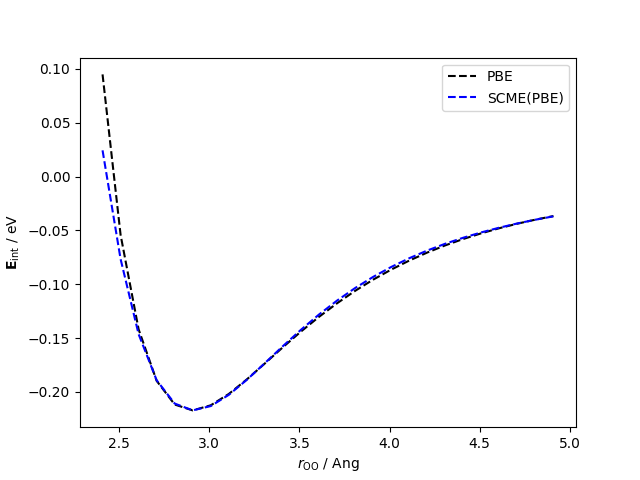

In [4]:
from IPython import display
display.Image("../data/fitDIMER.png", width=500, height=500)

In [5]:
from IPython import display
display.Image("../data/fitDIMERB.png", width=500, height=500)

# Dimer + Isomers set

The isomers are relaxed at each step using the current numerical values of the parameters.

Fit residual:
0.00438 eV

Fitted parameters are
|  Param. | Dim+Iso  | Dimer     |
| ------- | --------- | --------- |  
|$\tau_e$ | 1.021727 | 1.226809 | 
|$\tau_d$ | 3.869342 | 3.852983 |
|$A_r$    | 12597.02 | 8357.005 |
|$b_r$    | -1.12169e-5 | 0|
|$c_r$    | -3.87184| -3.800334|


|                             | Cs          | UUD        | S4         | CYC        | prism      |
| --------------              | ----------- |----------- | -----------| -----------| -----------|   
|$\mathbf{E}_\mathrm{bind}$ PBE   | -0.217268 | -0.673017 | -1.195165 | -1.578668 | -1.916297 |
|$\mathbf{E}_\mathrm{bind}$ SCME(PBE) | -0.218403 | -0.697997 | -1.171626 | -1.532542  | -2.136199 |

# Dimer + crystal ice-Ih

Fit residual : 0.000508 eV

Fitted parameters are

Fitted parameters are
|  Param. | Dim+Ice   | Dimer     |
| ------- | --------- | --------- |  
|$\tau_e$ | 1.239966  | 1.260077 | 
|$\tau_d$ | 4.512311  | 6.726818 |
|$A_r$    | 8701.405  | 14500.45 |
|$b_r$    | 9.955842  | 9.983895 |
|$c_r$    | -7.523309 | -7.691438 |

In [1]:
from ase.units import kJ                                                                             
from ase.eos import EquationOfState
import numpy as np
import pylab as pl
 
volume = np.array([29.745665,30.514950,31.284234,
                   32.053519,32.822803,33.592087,
                   34.361372])
 
energy = np.array([-56.440458,-56.930161,-57.224262,
                   -57.319996,-57.286621,-57.117458,
                   -56.838574])

scme_energy = np.array([-0.58704162, -0.59185869, -0.59484584, -0.59689689, -0.59742266, -0.59687277,
 -0.59536403])

energy /= 96.0
 
eos = EquationOfState(volume, energy)
v0n, e0n, Bn = eos.fit()
print(Bn / kJ * 1.0e24, 'GPa PBE')
print(v0n, 'V0 PBE')
print(e0n, 'E0 PBE')

eos = EquationOfState(volume, scme_energy)
v0n, e0n, Bn = eos.fit()
print(Bn / kJ * 1.0e24, 'GPa SCME(PBE)')
print(v0n, 'V0 SCME(PBE)')
print(e0n, 'E0 SCME(PBE)')

eos.plot()
 
pl.plot(volume, energy, 'k--')
pl.plot(volume, scme_energy, 'b--')
pl.ylabel('$\mathbf{E}_\mathrm{coh}$ eV')
pl.xlabel('Volume / molecule $\AA^3$')
pl.show()

13.186884373738515 GPa PBE
32.20697568737189 V0 PBE
-0.5971824274945412 E0 PBE
9.948617218088833 GPa SCME(PBE)
32.83783418024441 V0 SCME(PBE)
-0.5974180988633702 E0 SCME(PBE)
